# Importer les packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

C:\Users\yanth\VSCodeProjects\MGL869-Lab-Hive\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Charger les données

Les données sont chargées, et les colonnes comportants des nombres flottants sont réadapter pour pandas.

In [15]:
data = pd.read_csv('labeled_full_metrics_release-2.0.0.csv')
liste = ['CCViolDensityLine','CCViolDensityCode','RatioCommentToCode']
for elm in liste:
    data[elm] = data[elm].str.replace(',', '.').astype(float)
data[['Name','CountStmtDecl','BugStatus']].head(50)

,Name,CountStmtDecl,BugStatus
0,AMReporter.java,129,0
1,ASTBuilder.java,55,1
2,ASTConverter.java,220,1
3,ASTErrorNode.java,13,0
4,ASTNode.java,67,1
5,ASTNodeOrigin.java,13,0
6,ATSHook.java,62,1
7,AbortDroneException.java,5,0
8,AbortTxnRequest.java,91,0
9,AbstractBucketJoinProc.java,137,0


# Préparation des variables
La version du commit, son id et le nom du fichier n'est pas pris en compte dans l'entraînement du modèle. Toutes les colonnes comportant un `NaN` sont inutilisables et supprimées.

In [3]:
X = data.drop(columns=['BugStatus','Version','CommitId', 'Name']) # variables indépendantes
X = X.dropna(axis=1)
y = data['BugStatus'] # présence d'un bug

# Données d'entraînements et de test
L'ensemble des données est divisé en 10 parties égales sur lesquelles le modèle s'entraîne. La validation est réalisée [de manière croisée](https://medium.com/@tubelwj/five-methods-for-data-splitting-in-machine-learning-27baa50908ed) pour déterminer plus précisément l'efficacité de notre modèle.

In [4]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_test = y.iloc[train_index], y.iloc[val_index]

# Entrainement du modèle

Comparaison entre la régression logistique et la forêt aléatoire.

In [5]:
model1 = LogisticRegression()
model2 = RandomForestClassifier(n_estimators=100, random_state=42)

model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

C:\Users\yanth\VSCodeProjects\MGL869-Lab-Hive\venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier(random_state=42)

# Prédictions

In [6]:
y_pred1 = model1.predict(X_test)
print("Prédictions logistic regression :", y_pred1[:5],"..")
y_pred2 = model2.predict(X_test)
print("Prédictions random forest :", y_pred2[:5],"..")
print("Valeurs réelles :", y_test.values[:5],"..")

Prédictions logistic regression : [0 0 0 0 0] ..
Prédictions random forest : [0 0 0 0 0] ..
Valeurs réelles : [1 0 0 0 0] ..


# Evaluer la performance du modèle

Les 2 modèles sont comparés par leur AUC, leur précision et leur taux de rappel. La **forêt aléatoire** est un meilleur modèle pour la détermination de la présence de bugs dans un commit.

In [7]:
auc1 = roc_auc_score(y_test, y_pred1)
auc2 = roc_auc_score(y_test, y_pred2)

print(classification_report(y_test, y_pred1))
print(f"AUC Logistic Regression: {auc1}")
print("-"*60)

print(classification_report(y_test, y_pred2))
print(f"AUC Random Forest: {auc2}")

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       391
           1       0.45      0.16      0.23        64

    accuracy                           0.85       455
   macro avg       0.66      0.56      0.58       455
weighted avg       0.82      0.85      0.82       455

AUC Logistic Regression: 0.5627797314578006
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.98      0.94       391
           1       0.70      0.30      0.42        64

    accuracy                           0.88       455
   macro avg       0.80      0.64      0.68       455
weighted avg       0.87      0.88      0.86       455

AUC Random Forest: 0.638207320971867


# Importance des variables

## Valeur SHAP

Pour déterminer si une variable est plus importante qu'une autre dans la détermination de la présence d'un bug, on utilise [sa valeur **SHAP** (**SH**apley **A**dditive ex**P**lanations)](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137). Elle mesure la contribution d'une variable dans la prédiction du modèle.

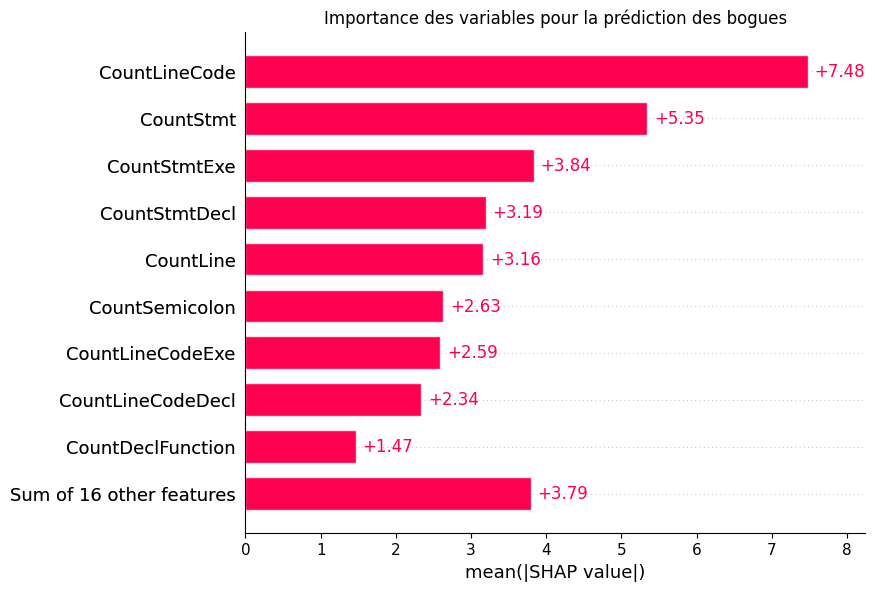

In [8]:
explainer = shap.Explainer(model1, X_train)
shap_values = explainer(X_test)

shap.plots.bar(shap_values, show=False)
plt.title("Importance des variables pour la prédiction des bogues")
plt.savefig('mon_graphique.png')
plt.show()

## Sélection des meilleures valeurs

On utilise uniquement les 5 meilleures variables pour l'entraînement et la prédication des variables.

In [9]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
mean_shap = shap_df.abs().mean()
top_5_variables = mean_shap.nlargest(5)
print("Les 5 variables les plus importantes :")
print(top_5_variables)
top_5_variables = top_5_variables.index.tolist()

Les 5 variables les plus importantes :
CountLineCode    7.480286
CountStmt        5.346257
CountStmtExe     3.837713
CountStmtDecl    3.193755
CountLine        3.163755
dtype: float64


In [10]:
X_5 = data[top_5_variables] # variables indépendantes
y_5 = data['BugStatus'] # présence d'un bug

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_5):
    X_train, X_test = X_5.iloc[train_index], X_5.iloc[val_index]
    y_train, y_test = y_5.iloc[train_index], y_5.iloc[val_index]

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train) # modèle forêt aléatoire
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_pred)
print(f"AUC Random Forest: {auc}")

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       391
           1       0.53      0.27      0.35        64

    accuracy                           0.86       455
   macro avg       0.71      0.61      0.64       455
weighted avg       0.84      0.86      0.84       455

AUC Random Forest: 0.6136309143222507


- CountLineCode : Lines of code
- CountStmt : Statements
- CountStmtExe : Executable statements
- CountStmtDecl : Declarative statements
- CountLine : Number of lines

# Actions à prendre
## 1. Réduire la complexité du code
`CountLineCode` et `CountStmtExe` sont des variables importantes pour la prédiction de bug. En effet, plus le `CountLineCode` et le `CountStmtExe` est grand, plus la présence de bug dans le fichier est probable.

**Solution** : Adopter une architecture modulaire.

**Exemple** : HiveConf.java contenait 3249 lignes de code et 676 instructions dans la release-2.0.0. Elle pourrait être décomposée en plusieurs modules, même si ces derniers existent mais ont peu de lignes de code (HiveConfUtil.java qui contient 8 lignes de code et 5 instructions).



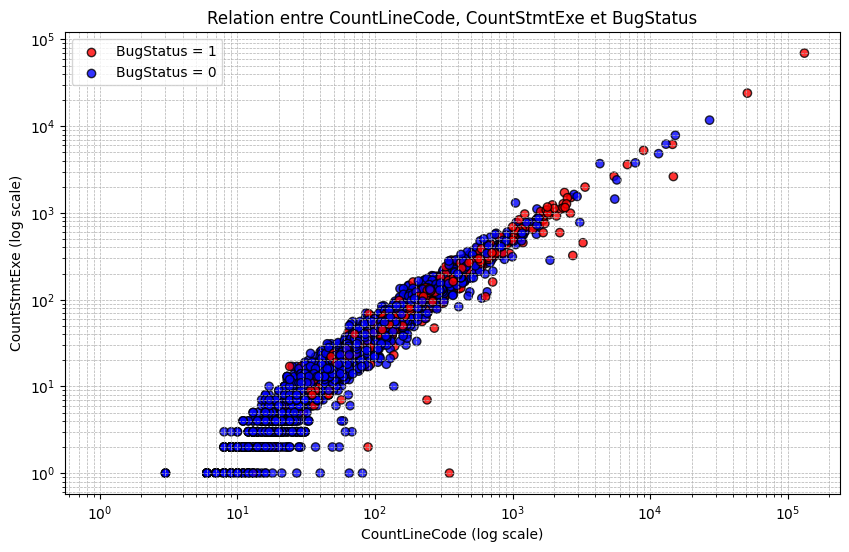

In [11]:
plt.figure(figsize=(10, 6))
colors = data['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data['CountLineCode'], data['CountStmtExe'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.yscale('log')

plt.xlabel('CountLineCode (log scale)')
plt.ylabel('CountStmtExe (log scale)')
plt.title('Relation entre CountLineCode, CountStmtExe et BugStatus')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.scatter([], [], c='red', label='BugStatus = 1', alpha=0.8, edgecolors='k')
plt.scatter([], [], c='blue', label='BugStatus = 0', alpha=0.8, edgecolors='k')
plt.legend()

plt.show()

## 2. Favoriser une meilleure lisibilité du code
`CountLines` est une variable importante. Plus `CountLines` est grand, plus la présence d'un bug dans le fichier est probable.

**Solution** : Formatter uniformément le code (respect des standards de codage), ajouter des commentaires pertinents et concis, simplifier le code.

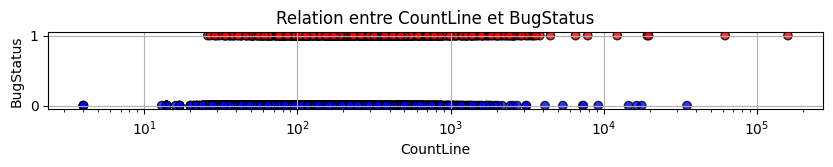

In [13]:
plt.figure(figsize=(10, 1))
colors = data['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data['CountLine'], data['BugStatus'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.xlabel('CountLine')
plt.ylabel('BugStatus')
plt.title('Relation entre CountLine et BugStatus')
plt.grid(True)
plt.show()

## 3. Eliminer les déclarations non essentielles
`CountStmtDecl` indique un excès de variables.

**Solution** : Supprimer les variables, les méthodes et les classes inutiles, réutiliser des variables, des méthodes et des classes déjà déclarées.

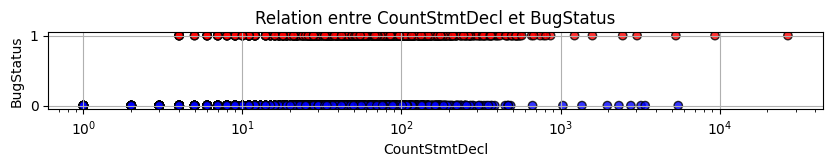

In [14]:
plt.figure(figsize=(10, 1))
colors = data['BugStatus'].map({0: 'blue', 1: 'red'})  # BugStatus=1 en rouge, 0 en bleu
plt.scatter(data['CountStmtDecl'], data['BugStatus'], c=colors, alpha=0.8, edgecolors='k')

plt.xscale('log')
plt.xlabel('CountStmtDecl')
plt.ylabel('BugStatus')
plt.title('Relation entre CountStmtDecl et BugStatus')
plt.grid(True)
plt.show()

## 4. Automatiser tests unitaires et d'intégration
`CountStmtExe` est une variable importante. Cela indique que la plupart des bugs proviennent d'instructions exécutables.

**Solution** : Adopter un logging dans tous les fichiers contenant des instructions exécutables. Améliorer la couverture des tests.

**Exemple** : `TSetIpAddressProcessor.java` contient un logging et n'a pas de bug, alors que `ASTBuilder.java` n'en possède pas et a un bug.

## 5. Eviter les grandes fonctionnalités monolithiques
`CountLineCode` et `CountStmt` signale des fonctionnalités trop volumineuse.
Adopter une architecture modulaire.
Exemple : HiveConf.java contenait 3249 lignes de code et 676 instructions dans la release-2.0.0. Elle pourrait être décomposée en plusieurs modules, même si ces derniers existent mais ont peu de lignes de code (HiveConfUtil.java qui contient 8 lignes de code et 5 instructions).